In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path

# import custom functions from src folder
module_path = str(Path.cwd() / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from robot import Robot

In [23]:
color = ["#e41a1c", "#4daf4a"]

In [24]:
myRobot = Robot()
data = myRobot.simulate(5000, black_box=False)

In [25]:
data

,color,x1,x2,a1,a2,r1,r2
0,red,9.882349,-9.912285,5.354368,2.420953,16.110393,3
1,red,-4.032228,9.440260,1.689384,1.846092,10.666505,3
2,green,-9.444775,0.734605,2.787982,1.036219,7.586366,3
3,red,12.183987,-0.608284,6.030686,0.958424,10.225181,3
4,green,-5.048691,-5.194481,3.533872,1.866472,7.525178,3
...,...,...,...,...,...,...,...
4995,red,-12.595374,3.345485,2.700455,0.901413,10.956484,3
4996,green,10.081136,1.951494,6.221569,1.027846,8.391843,3
4997,green,6.697887,-0.081378,5.865421,2.063570,7.574089,3
4998,red,-9.824837,-8.883085,3.699242,0.893643,11.157524,3


<Axes: xlabel='x1', ylabel='x2'>

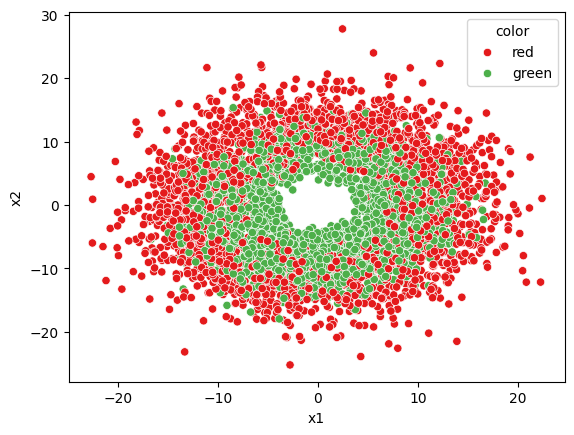

In [26]:
sn.scatterplot(data, x="x1", y="x2", hue="color", palette=color)

<Axes: xlabel='r1', ylabel='Count'>

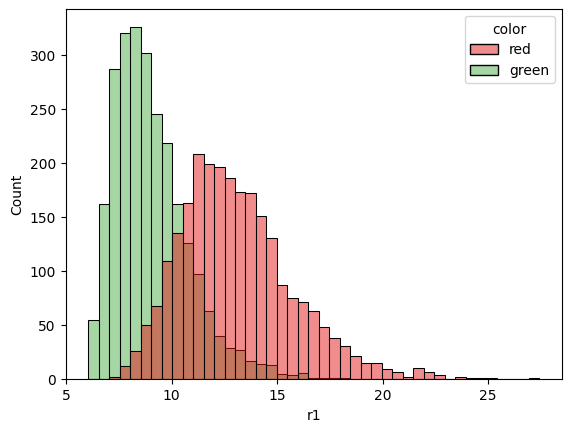

In [27]:
sn.histplot(data, x="r1", hue="color", palette=color)

<Axes: xlabel='a1', ylabel='Count'>

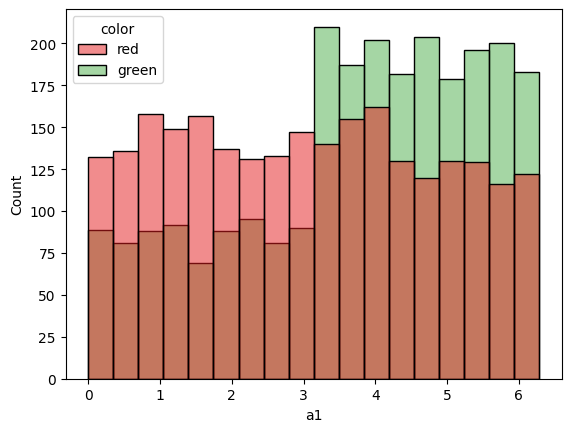

In [28]:
sn.histplot(data, x="a1", hue="color", palette=color)

<Axes: xlabel='x1', ylabel='Count'>

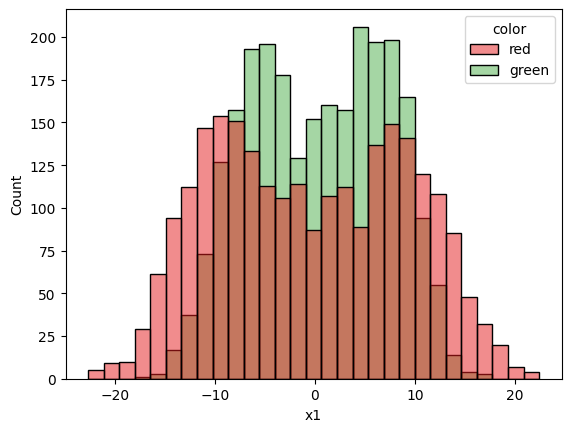

In [29]:
sn.histplot(data, x="x1", hue="color", palette=color)

<Axes: xlabel='x2', ylabel='Count'>

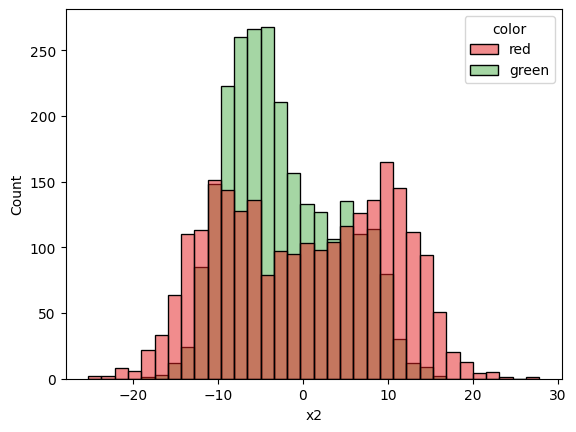

In [30]:
sn.histplot(data, x="x2", hue="color", palette=color)

<Axes: xlabel='x1', ylabel='x2'>

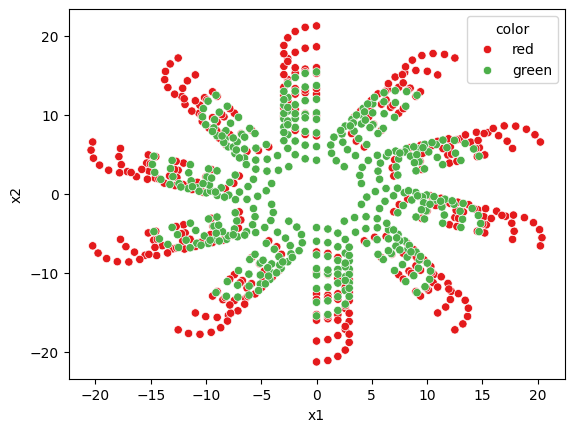

In [31]:
testdata = myRobot.gen_testdata(10, 10)
sn.scatterplot(testdata, x="x1", y="x2", hue="color", palette=color)

In [32]:
params = myRobot.get_parameters()
params

{'seed': 24, 'R2': 3, 'k_red': 7, 'k_green': 3, 'scale': 1}

In [33]:
# Save data
data.to_csv(f'../data/train_n_{len(data)}kr{params["k_red"]}_kg{params["k_green"]}_s{params["scale"]}_a1_highlow.csv', index=False)
testdata.to_csv(f'../data/test_n_{len(testdata)}kr{params["k_red"]}_kg{params["k_green"]}_s{params["scale"]}_a1_highlow.csv', index=False)